In [1]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx, NHITS, PatchTST
from neuralforecast.losses.pytorch import MAE
from neuralforecast.utils import AirPassengersDF
from sklearn.metrics import mean_absolute_error

# Set random seed
np.random.seed(42)

# %%
# Load dataset
df = pd.read_csv("data/Top_12_German_Companies_Financial_Data.csv")
companies = np.unique(df.Company)
company = companies[9]
print(f"Company: {company}")

# Filter for selected company
df = df[df["Company"] == company].copy()
df["Period"] = pd.to_datetime(df["Period"], format="%m/%d/%Y")
df = df.sort_values(by="Period")
df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")

# Convert to NeuralForecast format (column names: ["unique_id", "ds", "y"])
df_nf = df.rename(columns={"Company": "unique_id", "Period": "ds", "Revenue": "y"})
df_nf = df_nf[["unique_id", "ds", "y"]]

# Fill missing values (if any)
df_nf = df_nf.fillna(method="ffill")

# %%
# Train-validation-test split
train_size = int(len(df_nf) * 0.8)
val_size = int(len(df_nf) * 0.9)

train_df = df_nf.iloc[:train_size]
val_df = df_nf.iloc[train_size:val_size]
test_df = df_nf.iloc[val_size:]

# Forecast horizon (quarters)
H = 4
max_steps = 1000
# %%
# Define models with hyperparameters
models = [
    NBEATSx(h=2*H, input_size=3*H, loss=MAE(), max_steps=max_steps),
    NHITS(h=2*H, input_size=3*H, loss=MAE(), max_steps=max_steps),
    PatchTST(h=2*H, input_size=3*H, loss=MAE(), max_steps=max_steps)
]

# Train models using NeuralForecast
nf = NeuralForecast(models=models, freq='Q')
nf.fit(train_df)


Seed set to 1
Seed set to 1
Seed set to 1


Company: SAP SE
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s, v_num=39, train_loss_step=4.3e+8, train_loss_epoch=4.3e+8]  


In [2]:

# Validate models on validation set
val_predictions = nf.predict()
print(val_predictions)
# Compare with the first H points of the validation set (not the last)
val_actuals = val_df["y"].values  # First H validation points
print(val_actuals)
# Compute MAE for each model using the first H validation points
val_mae_scores = {model: mean_absolute_error(val_actuals, val_predictions[model].values[:len(val_actuals)]) for model in val_predictions.columns}
best_model_name = min(val_mae_scores, key=val_mae_scores.get)

print("\n🔹 Model Validation Performance:")
for model, mae in val_mae_scores.items():
    print(f"{model}: MAE = {mae:.2f}")

print(f"\n✅ Best Model Selected: {best_model_name}")




Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.41it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.77it/s]
                  ds       NBEATSx         NHITS      PatchTST
unique_id                                                     
SAP SE    2023-06-30  1.566195e+10  1.620627e+10  1.489384e+10
SAP SE    2023-09-30  1.530134e+10  1.493543e+10  1.298696e+10
SAP SE    2023-12-31  1.739223e+10  1.613981e+10  1.138139e+10
SAP SE    2024-03-31  1.781236e+10  1.575556e+10  8.567087e+09
SAP SE    2024-06-30  1.757185e+10  1.563337e+10  6.857025e+09
SAP SE    2024-09-30  1.819738e+10  1.703983e+10  7.295098e+09
SAP SE    2024-12-31  1.836473e+10  1.695560e+10  7.750687e+09
SAP SE    2025-03-31  1.914220e+10  1.765210e+10  9.533727e+09
[10806122549 17167661800 13414872686]

🔹 Model Validation Performance:
ds: MAE = 1696031986203781120.00
NBEATSx: MAE = 3566502252.33
NHITS: MAE = 3452436503.00
PatchTST: MAE = 3433968053.67

✅ Best Model Selected: PatchTST


In [4]:
# %%
# Use best model for test forecasting
best_model = [m for m in models if m.__class__.__name__ == best_model_name][0]
nf = NeuralForecast(models=[best_model], freq='Q')
nf.fit(pd.concat([train_df, val_df]))



Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s, v_num=45, train_loss_step=4.63e+8, train_loss_epoch=4.63e+8]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.23it/s]

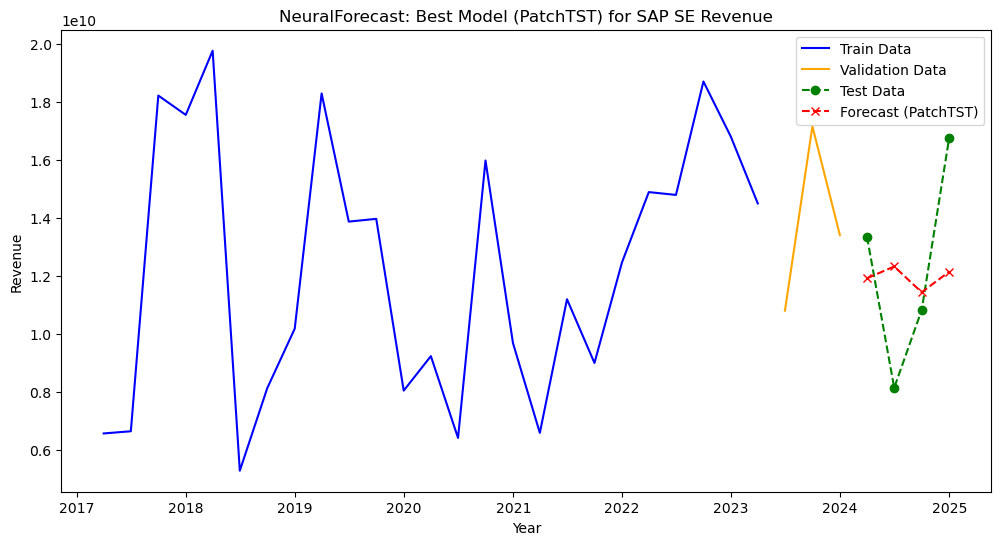

In [6]:
test_predictions = nf.predict()

# %%
# Plot actual vs. forecasted revenue
plt.figure(figsize=(12, 6))
plt.plot(train_df["ds"], train_df["y"], label="Train Data", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validation Data", color="orange")
plt.plot(test_df["ds"], test_df["y"], label="Test Data", color="green", linestyle="dashed", marker="o")
plt.plot(test_df["ds"], test_predictions[best_model_name].values[:len(test_df)], label=f"Forecast ({best_model_name})", linestyle="dashed", marker="x", color="red")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.title(f"NeuralForecast: Best Model ({best_model_name}) for {company} Revenue")
plt.legend()
plt.show()



In [7]:
# %%
# Evaluate final model on test data
test_mae = mean_absolute_error(test_df["y"].values, test_predictions[best_model_name].values[:len(test_df)])
print(f"\n📌 Final Test MAE ({best_model_name}): {test_mae:.2f}")


📌 Final Test MAE (PatchTST): 2708826167.75
